In [ ]:
# 🚀 Duke Datathon 2025 - Fluid Recommendation AFTER Guideline Injection

# Install and import
!pip install --upgrade openai tqdm
import openai
import pandas as pd
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
api_key = os.getenv("OPENAI_API_KEY")

# Pass it to the client
client = openai.OpenAI(api_key=api_key)

In [ ]:
!pip install pymupdf


In [ ]:
from google.colab import files

import fitz  # PyMuPDF

guideline_context = fitz.open("/content/surviving_sepsis_campaign__international.21.pdf")
full_text = ""

for page in doc:
    full_text += page.get_text()

print(len(full_text))  # Check how much text extracted

405814


In [ ]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=800,
    chunk_overlap=100
)

chunks = text_splitter.split_text(full_text)
print(f"Number of chunks: {len(chunks)}")

Number of chunks: 573


In [ ]:
!pip install sentence-transformers faiss-cpu

ERROR: Operation cancelled by user


In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Use mini model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Embed the chunks
embeddings = embedder.encode(chunks, convert_to_numpy=True)

# Build FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

In [ ]:
def retrieve_guideline(query, top_k=3):
    query_embedding = embedder.encode([query])
    D, I = index.search(np.array(query_embedding), top_k)
    retrieved = [chunks[i] for i in I[0]]
    return "\n\n".join(retrieved)

# Example query:
query = "fluid resuscitation initial amount sepsis"
context_from_guideline = retrieve_guideline(query)
print(context_from_guideline)

clinical practice (67).
Most patients require continued fluid adminis-
tration following initial resuscitation. Such admin-
istration needs to be balanced with the risk of fluid 
Recommendations
4.  Sepsis and septic shock are medical emergencies, 
and we recommend that treatment and resuscitation 
begin immediately.
Best practice statement.
5.  For patients with sepsis induced hypoperfusion or 
septic shock we suggest that at least 30 mL/kg of IV 
crystalloid fluid should be given within the first 3 hours 
of resuscitation.
Weak recommendation, low-quality evidence.
6.  For adults with sepsis or septic shock, we suggest 
using dynamic measures to guide fluid resuscitation 
over physical examination or static parameters alone.
Weak recommendation, very low-quality evidence.
Remarks:

77.	 Lara B, Enberg L, Ortega M, et al: Capillary refill time during 
fluid resuscitation in patients with sepsis-related hyperlactate-
mia at the emergency department is related to mortality. PLoS 
One

In [ ]:
# --- STEP 6: Define clinical case generation functions
def generate_baseline():
    age = random.randint(50, 80)
    sbp = random.randint(70, 90)
    dbp = random.randint(40, 60)
    hr = random.randint(90, 130)
    rr = random.randint(18, 30)
    temp_c = round(random.uniform(38.0, 40.0), 1)
    temp_f = round((temp_c * 9/5) + 32, 1)
    spo2 = random.randint(90, 98)
    gcs = random.randint(12, 15)
    wbc = random.randint(12000, 25000)
    creatinine = round(random.uniform(1.5, 3.5), 1)
    baseline_cr = round(random.uniform(0.8, 1.2), 1)
    lactate = round(random.uniform(2.5, 5.0), 1)
    urine_output = random.randint(0, 5)
    return {
        "age": age, "sbp": sbp, "dbp": dbp, "hr": hr, "rr": rr,
        "temp_c": temp_c, "temp_f": temp_f, "spo2": spo2, "gcs": gcs,
        "wbc": wbc, "creatinine": creatinine, "baseline_cr": baseline_cr,
        "lactate": lactate, "urine_output": urine_output
    }

def generate_cases_from_baseline(baseline):
    cases = []
    weights = [40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
    for weight in weights:
        case = baseline.copy()
        case['weight'] = weight
        # Add slight random noise to lactate and creatinine
        case['lactate'] += random.uniform(-0.2, 0.2)
        case['creatinine'] += random.uniform(-0.1, 0.1)
        cases.append(case)
    return cases

In [92]:
case_template = """
You are an ICU clinical decision support assistant.

You will receive:
- Excerpts from the sepsis clinical guideline.
- Daily ICU patient data.

TASK:
1. Read the guideline.
2. Read the patient case.
3. Based on the guideline ONLY, recommend the **amount of initial fluid resuscitation**.

⚠️ ONLY answer with a **numerical value in liters**.
⚠️ Do not explain.
⚠️ Do not write any text, units, or sentences.
⚠️ Example: 2.0

# Guideline context:
{guideline_context}

# Patient case:
A {age}-year-old patient with:
- BP: {sbp}/{dbp} mmHg
- HR: {hr} bpm
- RR: {rr} breaths/min
- Temp: {temp_c} °C ({temp_f} °F)
- SpO₂: {spo2}% on room air
- WBC: {wbc}/mm³
- Creatinine: {creatinine} mg/dL (baseline {baseline_cr})
- Lactate: {lactate} mmol/L
- Urine output: <{urine_output} mL/kg/hr
- Weight: {weight} kg
"""

import re

def extract_float(response):
    # Find the first number in the string
    match = re.search(r"[-+]?\d*\.\d+|\d+", response)
    if match:
        return float(match.group())
    else:
        return None

# --- STEP 8: GPT calling function
def ask_gpt(prompt, retries=3, delay=3):
    for _ in range(retries):
        try:
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(delay)
    return "ERROR"

In [93]:
df_guideline = pd.DataFrame({
    "Case_Info": all_cases,
    "Prompt": all_prompts,
    "Response": all_responses
})

# ✅ ADD THIS: create a clean Fluid_Liters column
df_guideline["Fluid_Liters"] = df_guideline["Response"].apply(lambda x: extract_float(x))

In [94]:
# --- STEP 9: Main loop (generate cases, retrieve guidelines, query GPT)
all_cases = []
all_prompts = []
all_responses = []

for i in tqdm(range(10), desc="Generating baselines and querying GPT"):
    baseline = generate_baseline()
    cases = generate_cases_from_baseline(baseline)

    for case in tqdm(cases, desc=f"Cases for baseline {i+1}", leave=False):
        # Dynamically retrieve relevant guideline for each case
        query = "fluid resuscitation initial amount sepsis"
        retrieved_context = retrieve_guideline(query)

        # Create full prompt
        full_prompt = case_template.format(guideline_context=retrieved_context, **case)
        # Ask GPT
        response = ask_gpt(full_prompt)

        # Store results
        all_cases.append(case)
        all_prompts.append(full_prompt)
        all_responses.append(response)

        time.sleep(1)  # Avoid rate limit

Generating baselines and querying GPT: 100%|██████████| 10/10 [02:31<00:00, 15.19s/it]


In [95]:
print(f"Baseline {i+1} -> Valid points: {len(weights)}")

Baseline 10 -> Valid points: 10


In [96]:
# After you finish generating
for i in range(10):
    print(f"\n=== Baseline {i+1} ===")
    baseline_cases = all_cases[i*10:(i+1)*10]
    for case in baseline_cases:
        print(case)


=== Baseline 1 ===
{'age': 56, 'sbp': 74, 'dbp': 55, 'hr': 116, 'rr': 20, 'temp_c': 38.5, 'temp_f': 101.3, 'spo2': 96, 'gcs': 15, 'wbc': 23471, 'creatinine': 2.9748956074885355, 'baseline_cr': 1.0, 'lactate': 4.468357212307739, 'urine_output': 5, 'weight': 40}
{'age': 56, 'sbp': 74, 'dbp': 55, 'hr': 116, 'rr': 20, 'temp_c': 38.5, 'temp_f': 101.3, 'spo2': 96, 'gcs': 15, 'wbc': 23471, 'creatinine': 2.974008065731246, 'baseline_cr': 1.0, 'lactate': 4.6135372954731935, 'urine_output': 5, 'weight': 50}
{'age': 56, 'sbp': 74, 'dbp': 55, 'hr': 116, 'rr': 20, 'temp_c': 38.5, 'temp_f': 101.3, 'spo2': 96, 'gcs': 15, 'wbc': 23471, 'creatinine': 2.988164492949272, 'baseline_cr': 1.0, 'lactate': 4.562466270143313, 'urine_output': 5, 'weight': 60}
{'age': 56, 'sbp': 74, 'dbp': 55, 'hr': 116, 'rr': 20, 'temp_c': 38.5, 'temp_f': 101.3, 'spo2': 96, 'gcs': 15, 'wbc': 23471, 'creatinine': 2.9719908880206822, 'baseline_cr': 1.0, 'lactate': 4.402273278229766, 'urine_output': 5, 'weight': 70}
{'age': 56, '

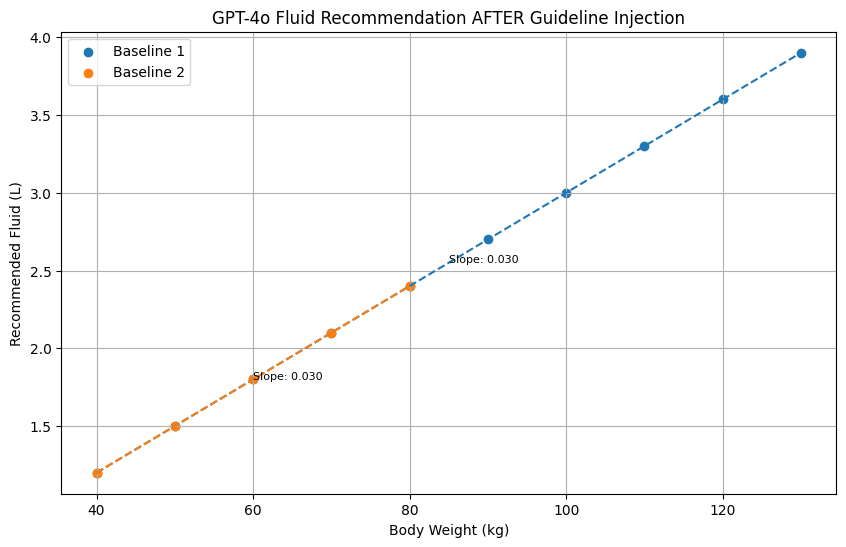

In [97]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

plt.figure(figsize=(10, 6))

for i in range(10):
    subset = df_guideline.iloc[i*10:(i+1)*10]

    weights = [case['weight'] for case in subset['Case_Info']]
    fluids = subset['Fluid_Liters'].tolist()

    weights = np.array(weights)
    fluids = np.array(fluids)

    # ❗ Mask NaNs
    mask = ~np.isnan(fluids)
    weights = weights[mask]
    fluids = fluids[mask]

    if len(weights) > 0:
        plt.scatter(weights, fluids, label=f'Baseline {i+1}')

        X = weights.reshape(-1, 1)
        y = fluids
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        slope = model.coef_[0]

        plt.plot(weights, y_pred, linestyle='--')
        plt.text(np.mean(weights), np.mean(fluids), f'Slope: {slope:.3f}', fontsize=8)

plt.xlabel('Body Weight (kg)')
plt.ylabel('Recommended Fluid (L)')
plt.title('GPT-4o Fluid Recommendation AFTER Guideline Injection')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## Experiments for gpt-4

In [ ]:
def ask_gpt(prompt, model="gpt-4o", retries=3, delay=3):
    for _ in range(retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(delay)
    return "ERROR"

In [ ]:
all_cases_gpt4 = []
all_prompts_gpt4 = []
all_responses_gpt4 = []

for i in tqdm(range(10), desc="Generating baselines and querying GPT-4"):
    baseline = generate_baseline()
    cases = generate_cases_from_baseline(baseline)

    for case in tqdm(cases, desc=f"Cases for baseline {i+1} (GPT-4)", leave=False):
        query = "fluid resuscitation initial amount sepsis"
        retrieved_context = retrieve_guideline(query)

        full_prompt = case_template.format(guideline_context=retrieved_context, **case)

        response = ask_gpt(full_prompt, model="gpt-4")

        all_cases_gpt4.append(case)
        all_prompts_gpt4.append(full_prompt)
        all_responses_gpt4.append(response)

        time.sleep(1)

In [ ]:
df_guideline_gpt4o = pd.DataFrame({
    "Case_Info": all_cases,
    "Prompt": all_prompts,
    "Response": all_responses
})

df_guideline_gpt4 = pd.DataFrame({
    "Case_Info": all_cases_gpt4,
    "Prompt": all_prompts_gpt4,
    "Response": all_responses_gpt4
})

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Plot GPT-4o
plt.figure(figsize=(12, 7))

for i in range(10):
    subset = df_guideline_gpt4o.iloc[i*10:(i+1)*10]
    weights = [case['weight'] for case in subset['Case_Info']]
    fluids = []

    for response in subset['Response']:
        try:
            fluids.append(float(response))
        except:
            fluids.append(np.nan)

    weights = np.array(weights)
    fluids = np.array(fluids)
    mask = ~np.isnan(fluids)
    weights = weights[mask]
    fluids = fluids[mask]

    if len(weights) > 0:
        plt.scatter(weights, fluids, color='blue', alpha=0.6, label=f'GPT-4o Baseline {i+1}' if i==0 else "")

# Plot GPT-4
for i in range(10):
    subset = df_guideline_gpt4.iloc[i*10:(i+1)*10]
    weights = [case['weight'] for case in subset['Case_Info']]
    fluids = []

    for response in subset['Response']:
        try:
            fluids.append(float(response))
        except:
            fluids.append(np.nan)

    weights = np.array(weights)
    fluids = np.array(fluids)
    mask = ~np.isnan(fluids)
    weights = weights[mask]
    fluids = fluids[mask]

    if len(weights) > 0:
        plt.scatter(weights, fluids, color='red', alpha=0.6, marker='x', label=f'GPT-4 Baseline {i+1}' if i==0 else "")

# Finishing touches
plt.xlabel('Body Weight (kg)')
plt.ylabel('Recommended Fluid (L)')
plt.title('GPT-4o vs GPT-4 Fluid Recommendation After Guideline Injection')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

plt.figure(figsize=(10, 6))

for i in range(10):
    subset = df_guideline_gpt4.iloc[i*10:(i+1)*10]

    weights = [case['weight'] for case in subset['Case_Info']]

    # Assuming your responses are still stored in 'Response' column as numbers
    fluids = []

    for response in subset['Response']:
        try:
            fluids.append(float(response))
        except:
            fluids.append(np.nan)

    weights = np.array(weights)
    fluids = np.array(fluids)

    # ❗ Mask NaNs
    mask = ~np.isnan(fluids)
    weights = weights[mask]
    fluids = fluids[mask]

    if len(weights) > 0:
        plt.scatter(weights, fluids, label=f'Baseline {i+1}')

        X = weights.reshape(-1, 1)
        y = fluids
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        slope = model.coef_[0]

        plt.plot(weights, y_pred, linestyle='--')
        plt.text(np.mean(weights), np.mean(fluids), f'Slope: {slope:.3f}', fontsize=8)

plt.xlabel('Body Weight (kg)')
plt.ylabel('Recommended Fluid (L)')
plt.title('GPT-4 Fluid Recommendation AFTER Guideline Injection')
plt.legend()
plt.grid(True)
plt.show()